#RNA Quantification and expression modeling

##load Libraries/Settings

In [1]:
#@title Set up conda on notebook
%%capture
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
import sys 
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

sys.path.append('/usr/local/lib/python3.7/site-packages/')


Install the required non python tools for QC and RNA Quant

In [3]:
#@title Install the programs you need
%%capture
# FastQC is a program designed to spot potential problems in high throughput sequencing datasets. 
!conda install -c bioconda fastqc -y
# Multiqc can aggregate and summarize all the QC data and alignment log data in one file 
!pip install multiqc
# Trimmomatic: A flexible read trimming tool for Illumina NGS data 
!conda install -c bioconda trimmomatic -y
# Kallisto is a program for quantifying abundances of transcripts from RNA-Seq data, or more generally of target sequences using high-throughput sequencing reads 
!conda install -c bioconda kallisto -y

!conda install -c bioconda fastp -y

##Defaults

Set some of the Default Parameters

In [4]:
samples = '/content/filereport_read_run_PRJNA576691_tsv.txt'

## Load Data

In [ ]:
#!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR128/086/SRR12817586/SRR12817586_1.fastq.gz
#!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR128/086/SRR12817586/SRR12817586_2.fastq.gz
#!wget https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA668997&result=read_run&fields=study_accession,sample_accession,experiment_accession,run_accession,tax_id,scientific_name,fastq_ftp,submitted_ftp,sra_ftp&format=tsv&download=true&limit=0

--2022-08-06 17:09:08--  https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA668997
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2022-08-06 17:09:09 ERROR 400: Bad Request.



Download reference for psudoalingment 

In [7]:
!wget ftp://ftp.ensembl.org/pub/release-99/fasta/homo_sapiens/ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz

--2022-08-07 22:40:22--  ftp://ftp.ensembl.org/pub/release-99/fasta/homo_sapiens/ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz
           => ‘Homo_sapiens.GRCh38.ncrna.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-99/fasta/homo_sapiens/ncrna ... done.
==> SIZE Homo_sapiens.GRCh38.ncrna.fa.gz ... 16490132
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.ncrna.fa.gz ... done.
Length: 16490132 (16M) (unauthoritative)

Homo_sapiens.GRCh38 100%[===================>]  15.73M  5.19MB/s    in 3.0s    

2022-08-07 22:40:28 (5.19 MB/s) - ‘Homo_sapiens.GRCh38.ncrna.fa.gz’ saved [16490132]



In [5]:
stream = os.popen("cat %s | awk -v FS='\t' '{print $7}' | sed 's/;/\\n/g'" % (samples) )
output = pd.read_table(stream)
output['fastq_ftp'][1]

for x in output['fastq_ftp']:
  os.system(f'wget {x}') 

'ftp.sra.ebi.ac.uk/vol1/fastq/SRR102/073/SRR10253273/SRR10253273_2.fastq.gz'

In [8]:
file = []
for i in output['fastq_ftp']:
  file.append(os.path.basename(i).split('_')[0])

file = set(file)
print(file)
  
#for i in file:
  #os.system(f"kallisto quant -i /content/Homo_sapiens.GRCh38.ncrna.fa.idx -o /content/{i}_quant /content/{i}_1.fastq.gz /content/{i}_2.fastq.gz")
  

{'SRR10253278', 'SRR10253302', 'SRR10253280', 'SRR10253283', 'SRR10253274', 'SRR10253292', 'SRR10253290', 'SRR10253300', 'SRR10253291', 'SRR10253277', 'SRR10253311', 'SRR10253306', 'SRR10253289', 'SRR10253296', 'SRR10253298', 'SRR10253279', 'SRR10253307', 'SRR10253303', 'SRR10253276', 'SRR10253313', 'SRR10253309', 'SRR10253286', 'SRR10253273', 'SRR10253293', 'SRR10253308', 'SRR10253281', 'SRR10253285', 'SRR10253297', 'SRR10253304', 'SRR10253284', 'SRR10253282', 'SRR10253310', 'SRR10253301', 'SRR10253312', 'SRR10253294', 'SRR10253299', 'SRR10253295', 'SRR10253275', 'SRR10253288', 'SRR10253305', 'SRR10253287'}


In [9]:
with open('/content/runNames.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(file))

##Process Data
- Make Index
- fastQC
- Primer removeal/Trim
- MultiQC

In [8]:
!kallisto index -i /content/Homo_sapiens.GRCh38.ncrna.fa.idx /content/Homo_sapiens.GRCh38.ncrna.fa.gz


[build] loading fasta file /content/Homo_sapiens.GRCh38.ncrna.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 478 target sequences
[build] warning: replaced 3 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... tcmalloc: large alloc 1610612736 bytes == 0x666c2000 @  0x7f8624055887 0x4458e9 0x43d809 0x444fb7 0x41a39f 0x7f8622cf4c87 0x41cf89
done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 297451 contigs and contains 31746988 k-mers 



In [ ]:
!fastqc *.fastq.gz

Started analysis of SRR18165764.fastq.gz
Approx 5% complete for SRR18165764.fastq.gz
Approx 10% complete for SRR18165764.fastq.gz
Approx 15% complete for SRR18165764.fastq.gz
Approx 20% complete for SRR18165764.fastq.gz
Approx 25% complete for SRR18165764.fastq.gz
Approx 30% complete for SRR18165764.fastq.gz
Approx 35% complete for SRR18165764.fastq.gz
Approx 40% complete for SRR18165764.fastq.gz
Approx 45% complete for SRR18165764.fastq.gz
Approx 50% complete for SRR18165764.fastq.gz
Approx 55% complete for SRR18165764.fastq.gz
Approx 60% complete for SRR18165764.fastq.gz
Approx 65% complete for SRR18165764.fastq.gz
Approx 70% complete for SRR18165764.fastq.gz
Approx 75% complete for SRR18165764.fastq.gz
Approx 80% complete for SRR18165764.fastq.gz
Approx 85% complete for SRR18165764.fastq.gz
Approx 90% complete for SRR18165764.fastq.gz
Approx 95% complete for SRR18165764.fastq.gz
Analysis complete for SRR18165764.fastq.gz


##Perform Quant

In [15]:
!cat /content/runNames.txt | xargs -n 1 -P 8 -I % kallisto quant -i /content/Homo_sapiens.GRCh38.ncrna.fa.idx -o /content/%_quant /content/%_1.fastq.gz /content/%_2.fastq.gz

[quant] running in paired-end mode
[quant] will process pair 1: /content/SRR10253274_1.fastq.gz
                             /content/SRR10253274_2.fastq.gz
[quant] finding pseudoalignments for the reads ...[quant] running in paired-end mode
[quant] will process pair 1: /content/SRR10253277_1.fastq.gz
                             /content/SRR10253277_2.fastq.gz
[quant] finding pseudoalignments for the reads ...[quant] running in paired-end mode
[quant] will process pair 1: /content/SRR10253276_1.fastq.gz
                             /content/SRR10253276_2.fastq.gz
[quant] finding pseudoalignments for the reads ...[quant] running in paired-end mode
[quant] will process pair 1: /content/SRR10253275_1.fastq.gz
                             /content/SRR10253275_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 15,159,237 reads, 3,015,376 reads pseudoaligned
[quant] estimated average fragment length: 171.018
[   em] quantifying the abundances ... done
[   e

##Generate Correlation / Adjacency Matrix

In [5]:
full_data = pd.DataFrame()
fields = ['target_id', 'est_counts']



for n,i in enumerate(file):
  path = '/content/'+i+'_quant/abundance.tsv'
  if os.path.exists(path):
    abundance = pd.read_table(path,
                              sep='\t', usecols=fields)
    abundance = abundance.rename(columns={"est_counts": f"{i}_counts"})
    abundance.astype({f"{i}_counts": 'int32'}).dtypes

    if n >= 1:
      full_data = pd.merge(full_data,abundance,on='target_id',how='left')
    else:
      full_data = abundance

full_data = full_data.transpose()
full_data.columns = full_data.iloc[0]
full_data = full_data[1:]
#full_data = full_data.set_index('target_id')
full_data.replace(0, np.nan, inplace=True)
full_data.to_csv('full_data.csv')

full_data

NameError: ignored

- If full_data has already been stored on dixk, use this to reload it if necessary

In [2]:
full_data = pd.read_csv('/content/full_data.csv', index_col=0)
full_data

,ENST00000516257.1,ENST00000410155.1,ENST00000517075.1,ENST00000384627.1,ENST00000363383.1,ENST00000391270.1,ENST00000516397.1,ENST00000410991.1,ENST00000517164.1,ENST00000612283.1,...,ENST00000633733.1,ENST00000631886.1,ENST00000631433.1,ENST00000635424.1,ENST00000636700.1,ENST00000636741.1,ENST00000637143.1,ENST00000638064.1,ENST00000636142.1,ENST00000626616.2
SRR10253278_counts,NaN,NaN,NaN,35.3086,NaN,1.0,NaN,2.00000,NaN,NaN,...,NaN,NaN,NaN,NaN,1.516050,NaN,0.500000,14.0,NaN,NaN
SRR10253274_counts,NaN,NaN,NaN,46.8146,1.0,1.0,NaN,1.00003,NaN,NaN,...,NaN,NaN,NaN,NaN,0.523247,NaN,0.500609,16.0,0.518088,0.5
SRR10253277_counts,NaN,NaN,NaN,48.2169,NaN,NaN,NaN,4.00013,NaN,NaN,...,NaN,0.111111,0.111111,NaN,0.500004,NaN,NaN,21.0,NaN,0.5
SRR10253279_counts,NaN,NaN,NaN,56.2028,NaN,NaN,NaN,5.00000,NaN,NaN,...,NaN,NaN,NaN,NaN,1.500010,NaN,NaN,20.5,NaN,NaN
SRR10253276_counts,NaN,NaN,NaN,57.5856,NaN,2.0,NaN,1.00003,NaN,NaN,...,NaN,NaN,0.250000,NaN,1.567560,NaN,NaN,16.0,1.050000,NaN
SRR10253273_counts,NaN,NaN,1.73524,62.6589,1.0,1.0,3.0,3.00000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500277,17.0,NaN,NaN
SRR10253275_counts,NaN,NaN,NaN,29.2447,1.0,NaN,NaN,NaN,NaN,0.5,...,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN


- Filter expression data down by removing empty values/non detection and very low expression

In [3]:
full_data = full_data.astype('float')
full_data = full_data.loc[:, (full_data.sum() >= 10)]
full_data.dropna(axis=1, inplace=True)

full_data

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,ENST00000384627.1,ENST00000617785.1,ENST00000384602.1,ENST00000613778.1,ENST00000516068.1,ENST00000364012.1,ENST00000516104.1,ENST00000384161.1,ENST00000617626.1,ENST00000410747.1,...,ENST00000618280.1,ENST00000480252.3,ENST00000461850.3,ENST00000627790.1,ENST00000625800.1,ENST00000630915.1,ENST00000640886.1,ENST00000646994.1,ENST00000673537.1,ENST00000638064.1
SRR10253278_counts,35.3086,1577.480,6.0,1577.480,3.000000,3.0,2.0,4.06910,5.51260,3.0,...,4.40916,2.0,6.00000,1.97252,18.3140,8.53497,2.75981,1.0,38.3773,14.0
SRR10253274_counts,46.8146,2228.760,17.0,2228.760,2.000000,3.0,4.0,4.17432,8.02251,4.0,...,19.61540,3.0,8.00000,3.32715,17.1610,13.00010,4.24043,2.0,43.2670,16.0
SRR10253277_counts,48.2169,1916.610,27.0,1916.610,2.000000,5.0,2.0,4.09961,7.01553,6.0,...,16.20710,4.0,4.45588,1.43618,30.0500,16.02990,6.30316,3.0,56.1031,21.0
SRR10253279_counts,56.2028,1822.980,13.0,1822.980,5.979880,5.0,8.0,3.82238,9.52329,6.0,...,15.36050,5.0,7.00000,3.32783,23.5881,15.92260,9.98358,4.0,54.6591,20.5
SRR10253276_counts,57.5856,1852.590,12.8,1852.590,2.331960,4.0,3.0,4.08987,11.02480,7.0,...,7.96342,5.0,4.00000,3.89946,31.8003,16.94730,8.19095,2.5,41.2521,16.0
SRR10253273_counts,62.6589,2218.100,15.0,2218.100,1.000000,5.0,3.0,8.16833,5.51591,4.0,...,12.18910,5.0,2.00000,3.08269,19.4116,13.70140,15.16130,0.5,44.9757,17.0
SRR10253275_counts,29.2447,965.433,6.0,965.433,0.954575,4.0,1.0,1.01619,5.51867,2.0,...,10.72590,1.0,4.00000,0.46480,17.3328,4.75267,2.71863,0.5,22.3128,11.0


- make a correlation matrix between genes

In [14]:
#corr_data = full_data.transpose()
#corr_data.columns = corr_data.iloc[0]
#corr_data = corr_data[1:]
#corr_data.set_index('target_id', drop=True)
corr_data = full_data.astype('float')
corr_data = corr_data.corr()
#full_data = full_data.set_index('target_id')
#full_data = full_data.mask(np.tril(np.ones(full_data.shape)).astype(bool))
corr_data

,ENST00000384627.1,ENST00000617785.1,ENST00000384602.1,ENST00000613778.1,ENST00000516068.1,ENST00000364012.1,ENST00000516104.1,ENST00000384161.1,ENST00000617626.1,ENST00000410747.1,...,ENST00000618280.1,ENST00000480252.3,ENST00000461850.3,ENST00000627790.1,ENST00000625800.1,ENST00000630915.1,ENST00000640886.1,ENST00000646994.1,ENST00000673537.1,ENST00000638064.1
ENST00000384627.1,1.000000,0.786193,0.468967,0.786193,0.225014,0.562528,0.537461,0.758366,0.518494,0.723760,...,0.273761,0.975831,-0.232077,0.800020,0.469499,0.866160,0.891770,0.412604,0.676160,0.672339
ENST00000617785.1,0.786193,1.000000,0.622239,1.000000,0.078781,0.151686,0.391424,0.796825,0.292819,0.497420,...,0.479619,0.716026,0.108041,0.741013,0.191702,0.754419,0.582669,0.298519,0.715301,0.631278
ENST00000384602.1,0.468967,0.622239,1.000000,0.622239,-0.060526,0.468873,0.094771,0.329918,0.198294,0.577437,...,0.673300,0.506183,-0.020312,0.135418,0.534699,0.691214,0.282125,0.500590,0.753052,0.783362
ENST00000613778.1,0.786193,1.000000,0.622239,1.000000,0.078781,0.151686,0.391424,0.796825,0.292819,0.497420,...,0.479619,0.716026,0.108041,0.741013,0.191702,0.754419,0.582669,0.298519,0.715301,0.631278
ENST00000516068.1,0.225014,0.078781,-0.060526,0.078781,1.000000,0.164049,0.854785,-0.108979,0.510113,0.440164,...,0.083305,0.352463,0.592267,0.375472,0.184742,0.377373,0.090606,0.761096,0.526197,0.515657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000630915.1,0.866160,0.754419,0.691214,0.754419,0.377373,0.470864,0.537246,0.494689,0.712119,0.939612,...,0.370983,0.924648,0.037332,0.726380,0.735598,1.000000,0.588898,0.735142,0.853101,0.850294
ENST00000640886.1,0.891770,0.582669,0.282125,0.582669,0.090606,0.716658,0.413870,0.808283,0.166855,0.424184,...,0.145159,0.837630,-0.498317,0.547195,0.231746,0.588898,1.000000,0.119591,0.483290,0.506320
ENST00000646994.1,0.412604,0.298519,0.500590,0.298519,0.761096,0.356453,0.716219,-0.116907,0.753128,0.810931,...,0.439784,0.561492,0.485522,0.402319,0.627795,0.735142,0.119591,1.000000,0.754178,0.792875
ENST00000673537.1,0.676160,0.715301,0.753052,0.715301,0.526197,0.510556,0.590312,0.487371,0.387333,0.735857,...,0.470133,0.756636,0.207854,0.466834,0.514127,0.853101,0.483290,0.754178,1.000000,0.981850


- Collapse matrix into an adjacency table

In [15]:
#np.fill_diagonal(corr_data.values,np.NaN)
corr_data = corr_data.rename_axis(None).rename_axis(None, axis=1)

corr_data = corr_data.stack().reset_index()
corr_data.columns = ['from', 'to', 'corr']
#full_data = full_data[full_data['corr'].notna()]
#full_data = full_data[(full_data['corr'] >= 0.5) | (full_data['corr'] <= -0.5)]
corr_data

,from,to,corr
0,ENST00000384627.1,ENST00000384627.1,1.000000
1,ENST00000384627.1,ENST00000617785.1,0.786193
2,ENST00000384627.1,ENST00000384602.1,0.468967
3,ENST00000384627.1,ENST00000613778.1,0.786193
4,ENST00000384627.1,ENST00000516068.1,0.225014
...,...,...,...
265168651,ENST00000638064.1,ENST00000630915.1,0.850294
265168652,ENST00000638064.1,ENST00000640886.1,0.506320
265168653,ENST00000638064.1,ENST00000646994.1,0.792875
265168654,ENST00000638064.1,ENST00000673537.1,0.981850


- keep only very correlated co-expression

In [16]:
corr_data = corr_data[(corr_data['corr'] >= 0.985) & (corr_data['corr'] != 1) | (corr_data['corr'] <= -0.985) & (corr_data['corr'] != -1)]
corr_data

,from,to,corr
541,ENST00000384627.1,ENST00000408639.1,0.987086
3441,ENST00000384627.1,ENST00000592187.1,0.989140
8281,ENST00000384627.1,ENST00000431986.2,0.992214
8397,ENST00000384627.1,ENST00000649889.1,0.992500
8486,ENST00000384627.1,ENST00000449882.2,0.991142
...,...,...,...
265162709,ENST00000638064.1,ENST00000449075.2,0.988914
265163141,ENST00000638064.1,ENST00000623740.1,0.988542
265165177,ENST00000638064.1,ENST00000450443.1,0.993227
265166619,ENST00000638064.1,ENST00000561624.2,0.989540


In [23]:


corr_data.to_csv('corr_data.csv')

##networkx/visulisation

In [8]:
import networkx as nx

- Plot whole network(can take a while!)

In [17]:
G=nx.from_pandas_edgelist(corr_data, 'from', 'to')
plt.figure(3,figsize=(20,20))
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, pos, with_labels=False)

KeyboardInterrupt: ignored

<Figure size 1440x1440 with 0 Axes>

-  make a sub-graph of largest component 

KeyboardInterrupt: ignored

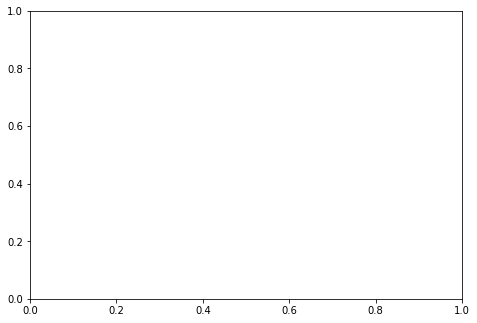

In [100]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
nx.draw(G0)

##Models

In [1]:
!pip install sbmltoodepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 8.8 MB/s 
  Created wheel for sbmltoodepy: filename=sbmltoodepy-1.0.4-py3-none-any.whl size=82394 sha256=a7799865c6cc861dc068883014be469b69e064684b9a569d12106545ee3629bf
  Stored in directory: /root/.cache/pip/wheels/52/55/c1/a869d0cbbec56865a2465fc84f8cfe2ab61cf8c095c722ffbd
Successfully built sbmltoodepy


In [5]:
import sbmltoodepy
from PythonFile import ModelName

In [3]:
!wget https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000828.10?filename=Jung2019+model.xml

--2022-08-08 09:50:22--  https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000828.10?filename=Jung2019+model.xml
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/xml]
Saving to: ‘BIOMD0000000828.10?filename=Jung2019+model.xml’

BIOMD0000000828.10?     [    <=>             ]  75.92K  76.4KB/s    in 1.0s    

2022-08-08 09:50:25 (76.4 KB/s) - ‘BIOMD0000000828.10?filename=Jung2019+model.xml’ saved [77740]



In [7]:
sbmltoodepy.ParseAndCreateModel("/content/BIOMD0000000828.10?filename=Jung2019+model.xml", outputFilePath = "PythonFile.py", className = "ModelName")
modelInstance = ModelName()

In [11]:
print(modelInstance.s.keys())
print(modelInstance.c.keys())
print(modelInstance.p.keys())
print(modelInstance.time)

dict_keys(['Glucose_G', 'Drug_D', 'miR_451_M', 'AMPK_A', 'mTOR_R', 'deltaD'])
dict_keys(['compartment'])
dict_keys(['myu_G', 'l_1', 'l_2', 'alpha', 'l_3', 'l_4', 'beta', 'S_1', 'epsilon_1', 'l_5', 'l_6', 'gamma', 'S_2', 'epsilon_2', 'myu_D', 'u_1', 'u_2'])
0


In [12]:
timeinterval = 1
modelInstance.RunSimulation(timeinterval)

In [16]:
import numpy as np
times = np.zeros(101)
times[0] = modelInstance.time
concentrations = np.zeros(101)
concentrations[0] = modelInstance.s['Glucose_G'].concentration

concentrations_drug = np.zeros(101)
concentrations_drug[0] = modelInstance.s['Glucose_G'].concentration

timeinterval = 1
for i in range(100):
	modelInstance.RunSimulation(timeinterval)
	times[i+1] = modelInstance.time
	concentrations[i+1] = modelInstance.s['Glucose_G'].concentration

IndentationError: ignored

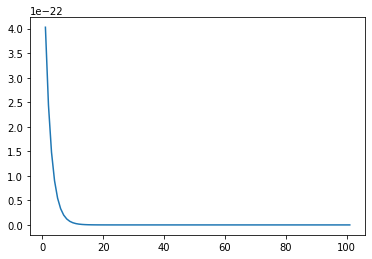

In [15]:
import matplotlib.pyplot as plt
plt.plot(times,concentrations)